In [1]:
import numpy as np

import pymc as pm
import graphviz
import arviz as az
az.style.use('seaborn')

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

/var/folders/kz/3m7b5b5n7n19qtpq86vft4ww0000gn/T/ipykernel_31534/1314631150.py:6: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  az.style.use('seaborn')


## Workflow
1. Generate data based on prior knowledge
2. Define model
* define prior distribution
* define distribution of likelihood funtion
3. Get posterior
* sample from posterior distribution
4. Posterior predictive checks
5. Make predictions

### 1. Generate data

In [2]:
num_samples = 5_000

# Draw sample from a uniform distribution as a weak prior
random_numbers = np.random.rand(num_samples)

# Adapt data to be more representative of expected default rates in Germany
default_rates = np.abs(random_numbers)*0.1

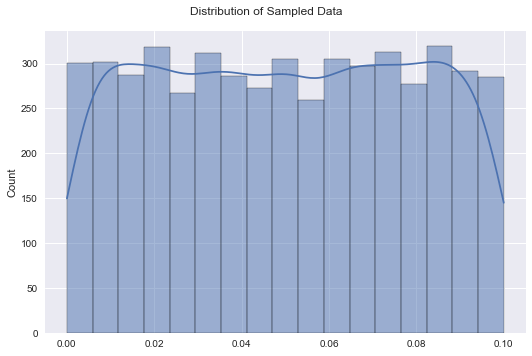

In [3]:
sample_distribution = sns.displot(
    data = default_rates,
    kde = True,
    aspect = 1.5
)

sample_distribution.fig.suptitle('Distribution of Sampled Data')

plt.tight_layout();

### 2 + 3. Specify model and *"push inference button"*

In [4]:
# Prior parameters
n_SMEs = 1_000
prob = 0.03

In [5]:
with pm.Model() as default_rate_model:
    # Prior for the default rate
    default_rate = pm.Beta('default_rate', alpha = 1, beta = 1)
    
    # Likelihood of the observed data
    defaults = pm.Gamma('defaults', alpha=default_rate * n_SMEs, beta=n_SMEs, observed=default_rates)
    
    # MCMC sampling
    trace = pm.sample(5_000, tune=2_500)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [default_rate]


Sampling 4 chains for 2_500 tune and 5_000 draw iterations (10_000 + 20_000 draws total) took 19 seconds.


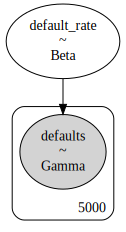

In [6]:
# plot causal relationships in model
pm.model_to_graphviz(default_rate_model)

### 4. Check posterior predictive

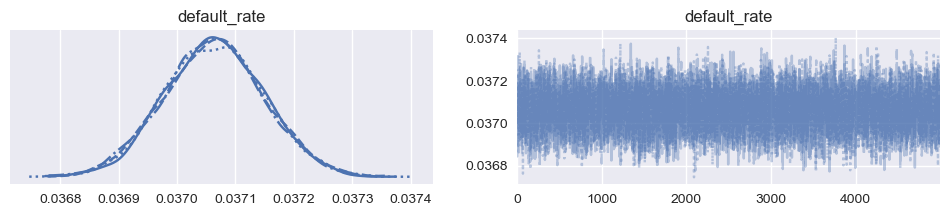

In [7]:
az.plot_trace(trace);

* stationarity (RHS - this is good (since this hints that `MCMC` actually converges...))
* note 4 chains (essentially all lying on top of each other, LHS-plot)

#### Summarize posterior

In [8]:
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
default_rate,0.037,0.0,0.037,0.037,0.0,0.0,9185.0,13923.0,1.0


* see mean value for `default_rate` sampled from posterior distribution (3.7%)
* see value for `r_hat`: the closer it is to `1`, the more the model converges

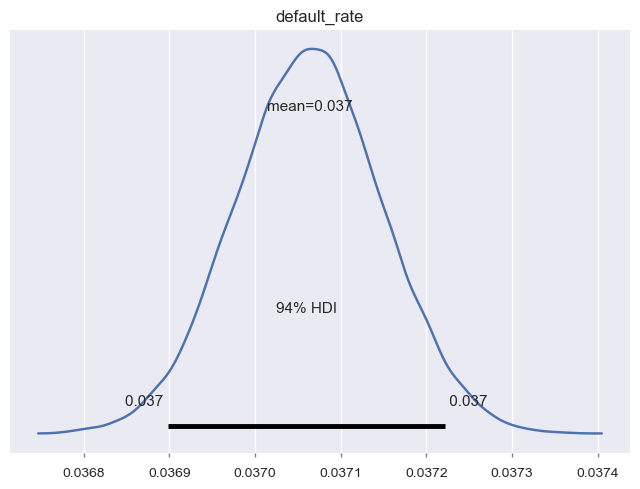

In [9]:
# Posterior analysis
az.plot_posterior(trace, var_names=['default_rate']);

* this is **bayesian**: we get a *distribution* for default rates (indicating our uncertainty around its mean value - as opposed to a (long-term) expected value for it)

#### Posterior predictive checks

In [10]:
# Perform posterior predictive checks and plot the results
ppc = pm.sample_posterior_predictive(trace, model=default_rate_model)

Sampling: [defaults]


#### Plot ppc

In [11]:
print(ppc.keys())

KeysView(Inference data with groups:
	> posterior_predictive
	> observed_data)


In [12]:
data = {"posterior_predictive": ppc["posterior_predictive"], "observed": default_rates}

In [13]:
# Plot the posterior predictive check
#az.plot_ppc(data, group="posterior", kind="kde")